In [1]:
import os
import numpy as np
import pandas as pd
import umap
import hdbscan
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import (
    pairwise_distances,
    silhouette_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    homogeneity_completeness_v_measure,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
    fowlkes_mallows_score,
)

from tqdm.notebook import tqdm

In [2]:
from src.data_loader import get_html_page_and_prepare_soup, get_content_list_from_html, load_model_results 
from src.data_stats import find_shape_of_datasets

### Loading data

#### Loading metrics

In [3]:
DATA_DIR_NAME = 'papers'
DATASET_DIR_NAME = DATA_DIR_NAME + '/' + 'datasets'
METRICS_DIR_NAME = DATA_DIR_NAME + '/' + 'metrics'

In [4]:
page_link = "https://timeseriesclassification.com/results/PublishedResults/"
soup_main = get_html_page_and_prepare_soup(page_link)
paper_list = get_content_list_from_html(soup_main, 'a')[1:]
paper_list

['Bakeoff2017/', 'Bakeoff2021/', 'Bakeoff2023/', 'HIVE-COTEV2/']

In [5]:
paper_models_dict = load_model_results(paper_list, METRICS_DIR_NAME, need_download=False)
scores = paper_models_dict['Bakeoff2023']
scores.keys()

Parsing Bakeoff2017 models...

Parsing Bakeoff2021 models...

Parsing Bakeoff2023 models...

Parsing HIVE-COTEV2 models...



dict_keys(['1NN-DTW', 'Arsenal', 'BOSS', 'CIF', 'CNN', 'Catch22', 'DrCIF', 'EE', 'FreshPRINCE', 'HC1', 'HC2', 'Hydra-MR', 'Hydra', 'InceptionT', 'Mini-R', 'MrSQM', 'Multi-R', 'PF', 'RDST', 'RISE', 'ROCKET', 'RSF', 'RSTSF', 'ResNet', 'STC', 'STSF', 'ShapeDTW', 'Signatures', 'TDE', 'TS-CHIEF', 'TSF', 'TSFresh', 'WEASEL-D', 'WEASEL', 'cBOSS'])

In [6]:
models = list(scores.keys())
datasets = (list(scores['cBOSS']["folds:"]))
table = {dataset : pd.DataFrame(columns=['model'] + list(scores['1NN-DTW'].columns[1:])) for dataset in datasets}

In [7]:
print(len(models), models[:5])
print(len(datasets), datasets[:5])

35 ['1NN-DTW', 'Arsenal', 'BOSS', 'CIF', 'CNN']
112 ['Adiac', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken']


In [8]:
import warnings
warnings.simplefilter('ignore')

In [9]:
for model in scores:
    metrix = scores[model]
    for i in range(len(metrix)):
        dataset = metrix.iloc[[i]]["folds:"].item()
        s = metrix.iloc[[i]]
        s.reset_index(drop=True, inplace=True)
        s["folds:"] = model
        s.rename(columns={"folds:": 'model'}, inplace=True)

        if dataset in table:
            table[dataset] = pd.concat([table[dataset], s], ignore_index=True)
ranks = table.copy()

for dataset in datasets:
    t = table[dataset].copy(deep=True)
    for i in range(30):
        t[str(i)][np.argsort(t[str(i)])] = np.arange(len(t[str(i)])) + 1
    ranks[dataset] = t

In [10]:
def get_ranks(selected_datasets):
    sum_ =  ranks[selected_datasets[0]].copy(deep=True)
    sum_[[str(i) for i in range(30)]] *= 0
    for dataset in selected_datasets:
        sum_[[str(i) for i in range(30)]] += ranks[dataset].copy(deep=True)[[str(i) for i in range(30)]]
    for i in range(30):
        sum_[str(i)][np.argsort(sum_[str(i)])] = np.arange(len(sum_[str(i)])) + 1
    return sum_

#### Loading features

In [11]:
tsfresh_features = pd.read_csv('data/tsfresh_important_features.csv', index_col=0)
tsfresh_features

,Name,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,Adiac,0,0,0,1,0,0,1,1,1,...,1,1,1,1,1,1,1,1,0,1
1,ArrowHead,0,0,0,0,0,0,1,1,0,...,1,1,1,1,1,1,1,1,0,1
2,Beef,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,BeetleFly,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,BirdChicken,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,EOGHorizontalSignal,0,0,0,0,1,1,1,1,0,...,1,1,1,1,1,1,1,1,0,1
105,EOGVerticalSignal,0,1,0,0,1,1,1,1,1,...,1,1,1,0,0,0,0,0,0,1
106,Rock,0,0,0,0,1,1,1,1,0,...,1,0,1,1,1,1,1,1,0,1
107,Crop,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1


In [12]:
chosen_datasets = tsfresh_features.Name.values
chosen_datasets[:5]

array(['Adiac', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken'],
      dtype=object)

In [13]:
features = pd.read_csv('data/features.csv', index_col=0)
features = features.set_index('Name')
features = features.loc[chosen_datasets, :]
features = features.reset_index()
features

,Name,entropy,gini,number_of_classes,size
0,Adiac,5.202000,0.972675,1.0,781.0
1,ArrowHead,1.576854,0.662833,1.0,211.0
2,Beef,2.321928,0.800000,1.0,60.0
3,BeetleFly,1.000000,0.500000,0.0,40.0
4,BirdChicken,1.000000,0.500000,0.0,40.0
...,...,...,...,...,...
104,EOGHorizontalSignal,3.584885,0.916658,1.0,724.0
105,EOGVerticalSignal,3.584885,0.916658,1.0,724.0
106,Rock,1.925301,0.723673,1.0,70.0
107,Crop,4.584963,0.958333,1.0,24000.0


## Clustering datasets by metrics

In [14]:
scores_aggr = {
    model: model_score[model_score["folds:"].isin(chosen_datasets)].reset_index(drop=True) for model, model_score in scores.items()
}

scores_aggr = {
    model: model_score.set_index("folds:").loc[chosen_datasets, :].reset_index() for model, model_score in scores_aggr.items()
}

scores_aggr = {
    model: model_score[model_score.columns[1:]].mean(axis=1) for model, model_score in scores_aggr.items()
}

scores_aggr = pd.DataFrame(scores_aggr)

scores_aggr

,1NN-DTW,Arsenal,BOSS,CIF,CNN,Catch22,DrCIF,EE,FreshPRINCE,HC1,...,STSF,ShapeDTW,Signatures,TDE,TS-CHIEF,TSF,TSFresh,WEASEL-D,WEASEL,cBOSS
0,0.603410,0.769224,0.745695,0.766922,0.387383,0.697187,0.811679,0.657374,0.808355,0.790878,...,0.813384,0.653367,0.700256,0.754902,0.779710,0.715686,0.789770,0.817818,0.793606,0.745780
1,0.722095,0.864762,0.860000,0.823238,0.759810,0.760000,0.828000,0.860381,0.788381,0.877524,...,0.789143,0.856000,0.773333,0.897524,0.881143,0.784190,0.613143,0.885143,0.879429,0.881714
2,0.504444,0.751111,0.630000,0.792222,0.667778,0.484444,0.794444,0.515556,0.791111,0.718889,...,0.790000,0.530000,0.632222,0.664444,0.632222,0.677778,0.734444,0.776667,0.718889,0.577778
3,0.775000,0.886667,0.940000,0.855000,0.791667,0.851667,0.885000,0.756667,0.881667,0.953333,...,0.905000,0.703333,0.761667,0.931667,0.958333,0.823333,0.500000,0.946667,0.920000,0.960000
4,0.840000,0.891667,0.980000,0.868333,0.705000,0.888333,0.951667,0.836667,0.923333,0.965000,...,0.961667,0.690000,0.691667,0.968333,0.963333,0.821667,0.608333,0.933333,0.906667,0.981667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,0.591344,0.804788,0.680387,0.782689,0.500829,0.724862,0.797514,0.782320,0.768508,0.797145,...,0.738674,0.646869,0.696409,0.719153,0.853683,0.692910,0.751197,0.749724,0.688858,0.710313
105,0.534807,0.774954,0.632965,0.763996,0.359300,0.674954,0.780295,0.736004,0.696041,0.760221,...,0.734162,0.539227,0.619797,0.693186,0.809484,0.663628,0.680018,0.691529,0.553131,0.639134
106,0.655333,0.804000,0.796667,0.830000,0.716000,0.766000,0.848000,0.757333,0.847333,0.862000,...,0.818667,0.701333,0.748000,0.870667,0.832000,0.764667,0.644667,0.876667,0.854000,0.808000
107,0.710748,0.739889,0.690855,0.778077,0.706524,0.691712,0.779589,0.732292,0.767915,0.768135,...,0.764036,0.713845,0.753990,0.718905,0.762101,0.751514,0.756284,0.758688,0.737942,0.701365


In [15]:
%%time
all_emb_2d = dict()

for n_neighbors in tqdm([2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 100]):
    projector = umap.UMAP(n_components=2, n_jobs=4, learning_rate=1.0, n_neighbors=n_neighbors, n_epochs=3000)
    all_emb_2d[n_neighbors] = projector.fit_transform(scores_aggr.values)

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 54.8 s, sys: 1.26 s, total: 56.1 s
Wall time: 30.3 s


  0%|          | 0/11 [00:00<?, ?it/s]

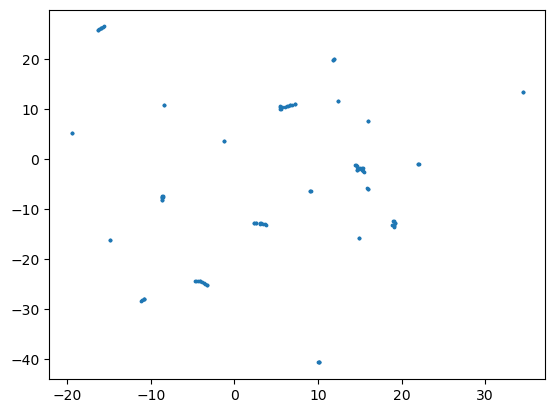

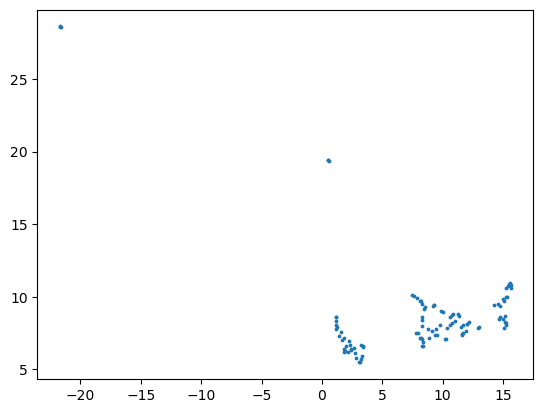

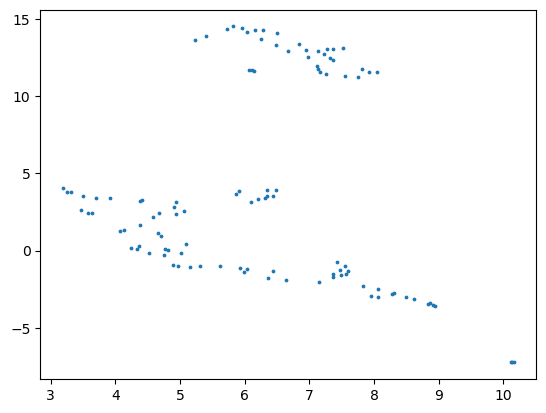

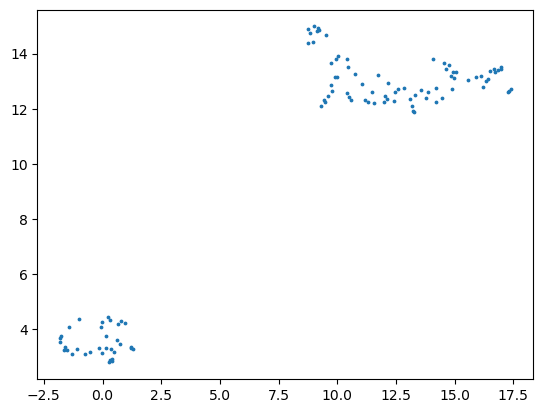

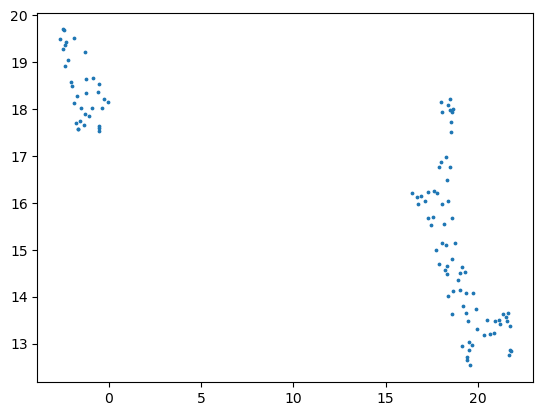

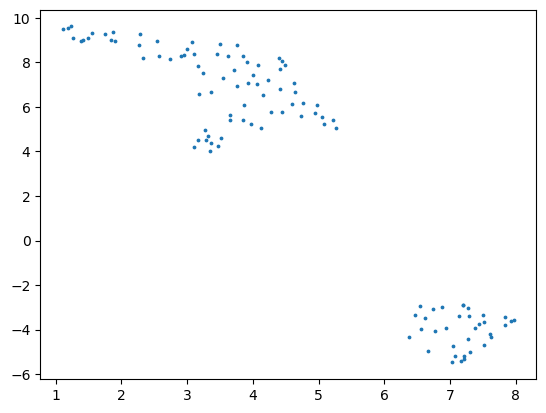

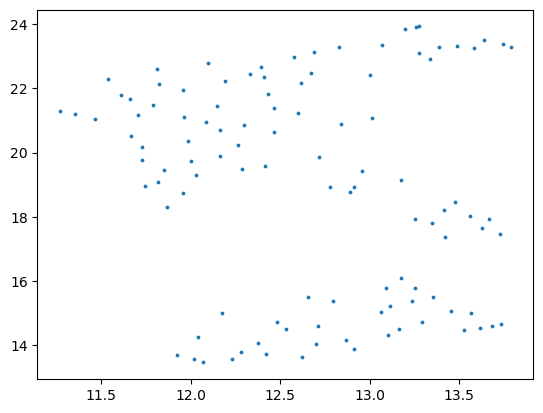

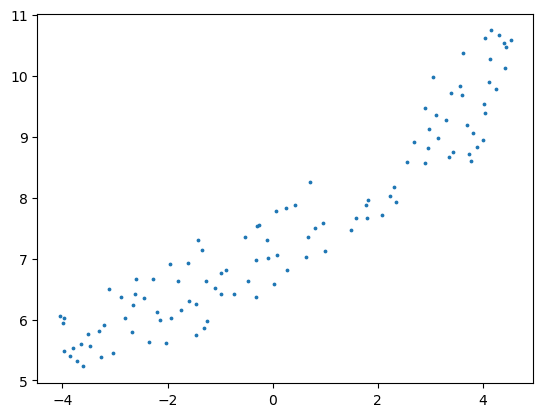

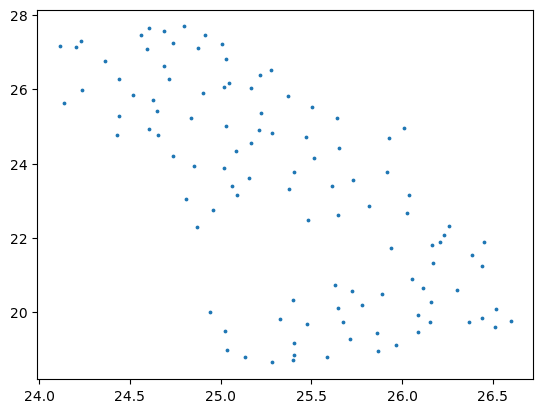

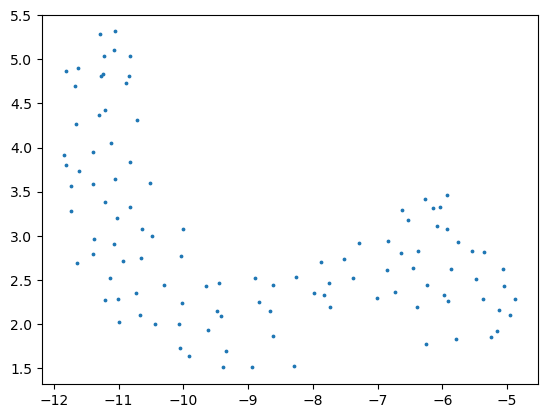

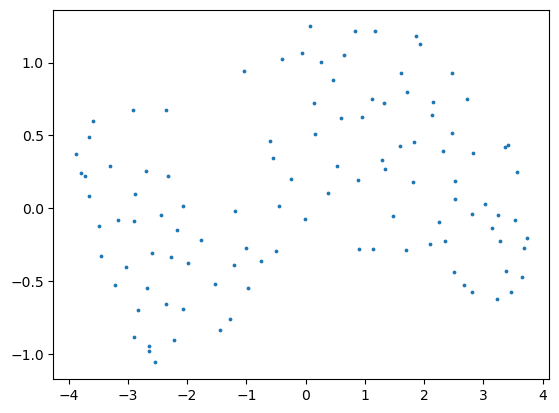

In [16]:
for n_neighbors in tqdm([2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 100]):
    plt.figure()
    plt.scatter(all_emb_2d[n_neighbors][:, 0], all_emb_2d[n_neighbors][:, 1], s=3)
    plt.show()

## Clustering features

### Simple features

In [17]:
prep_features = features.copy()
prep_features = prep_features.drop(columns=['Name'])
prep_features['size'] = np.log(prep_features['size'])
prep_features

,entropy,gini,number_of_classes,size
0,5.202000,0.972675,1.0,6.660575
1,1.576854,0.662833,1.0,5.351858
2,2.321928,0.800000,1.0,4.094345
3,1.000000,0.500000,0.0,3.688879
4,1.000000,0.500000,0.0,3.688879
...,...,...,...,...
104,3.584885,0.916658,1.0,6.584791
105,3.584885,0.916658,1.0,6.584791
106,1.925301,0.723673,1.0,4.248495
107,4.584963,0.958333,1.0,10.085809


In [18]:
%%time
all_emb_2d_features = dict()

for n_neighbors in tqdm([2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 100]):
    projector = umap.UMAP(n_components=2, n_jobs=4, learning_rate=1.0, n_neighbors=n_neighbors, n_epochs=3000)
    all_emb_2d_features[n_neighbors] = projector.fit_transform(prep_features.values)

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 47 s, sys: 1.02 s, total: 48 s
Wall time: 24.6 s


  0%|          | 0/11 [00:00<?, ?it/s]

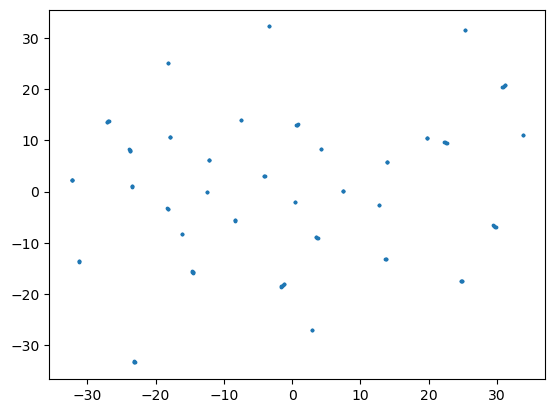

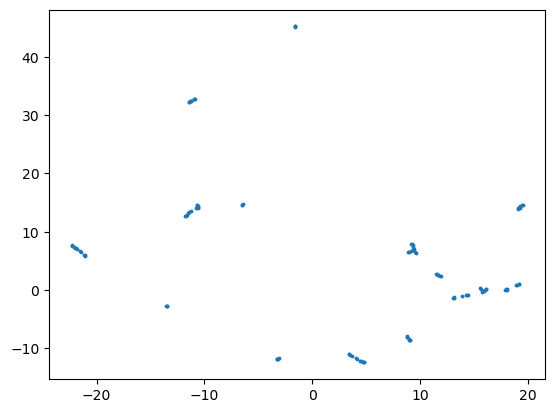

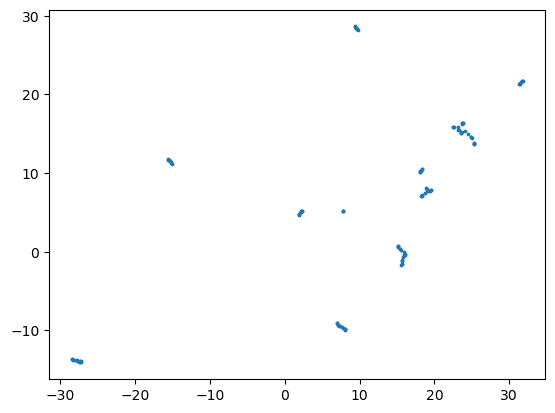

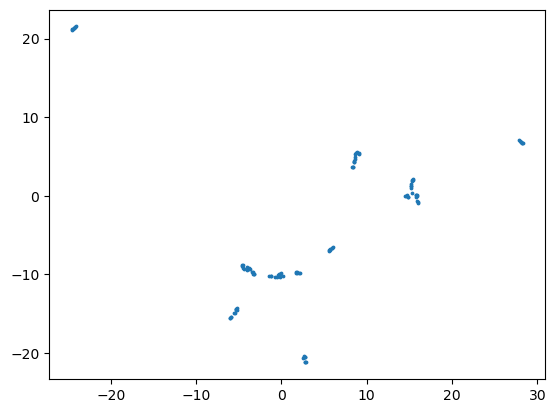

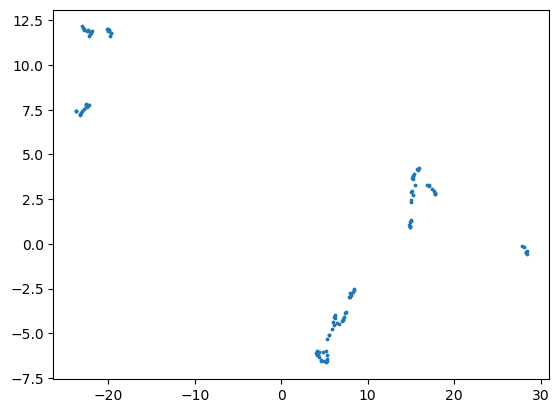

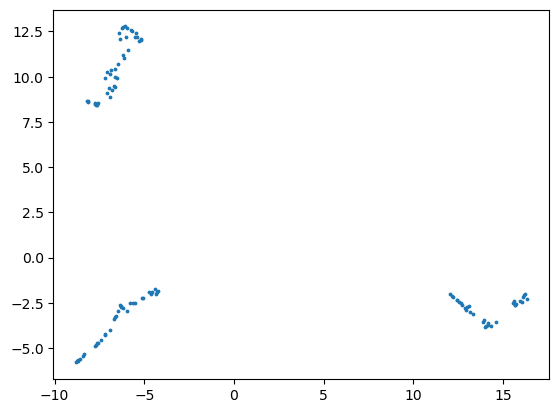

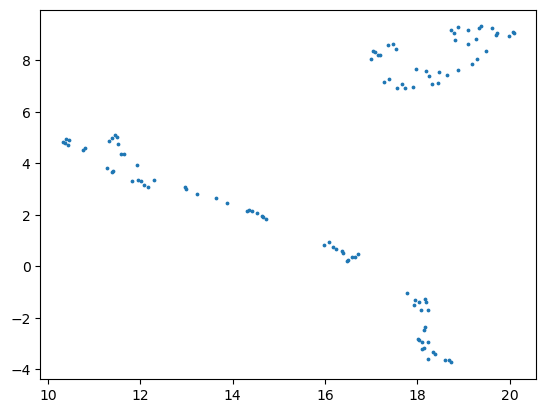

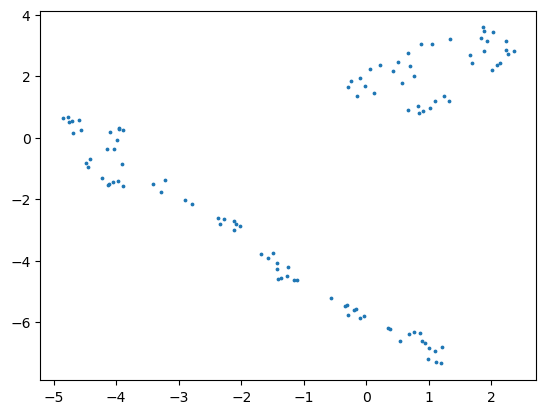

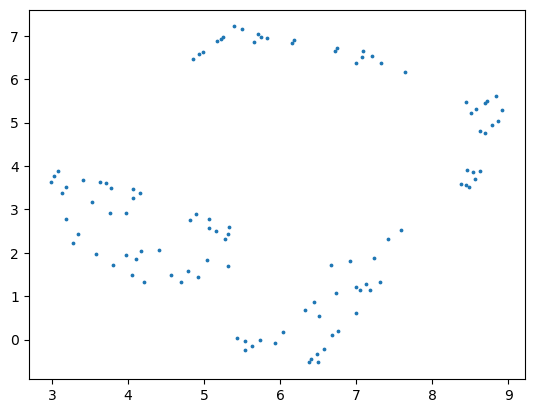

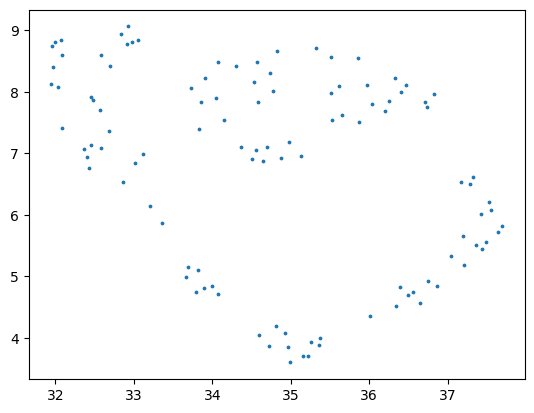

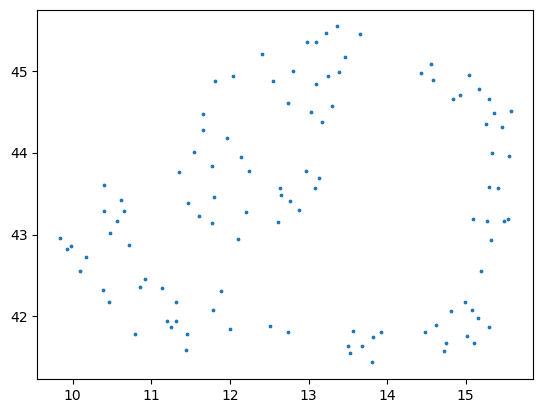

In [19]:
for n_neighbors in tqdm([2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 100]):
    plt.figure()
    plt.scatter(all_emb_2d_features[n_neighbors][:, 0], all_emb_2d_features[n_neighbors][:, 1], s=3)
    plt.show()

### tsfresh features

In [20]:
prep_tsfresh_features = tsfresh_features.copy()
prep_tsfresh_features = prep_tsfresh_features.drop(columns=['Name'])
prep_tsfresh_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0,0,0,1,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
1,0,0,0,0,0,0,1,1,0,1,...,1,1,1,1,1,1,1,1,0,1
2,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,0,0,0,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,0,1
105,0,1,0,0,1,1,1,1,1,1,...,1,1,1,0,0,0,0,0,0,1
106,0,0,0,0,1,1,1,1,0,1,...,1,0,1,1,1,1,1,1,0,1
107,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1


In [21]:
%%time
all_emb_2d_tsfresh_features = dict()

for n_neighbors in tqdm([2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 100]):
    projector = umap.UMAP(n_components=2, n_jobs=4, learning_rate=1.0, n_neighbors=n_neighbors, n_epochs=3000)
    all_emb_2d_tsfresh_features[n_neighbors] = projector.fit_transform(prep_tsfresh_features.values)

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 57.2 s, sys: 1.57 s, total: 58.8 s
Wall time: 27.1 s


  0%|          | 0/11 [00:00<?, ?it/s]

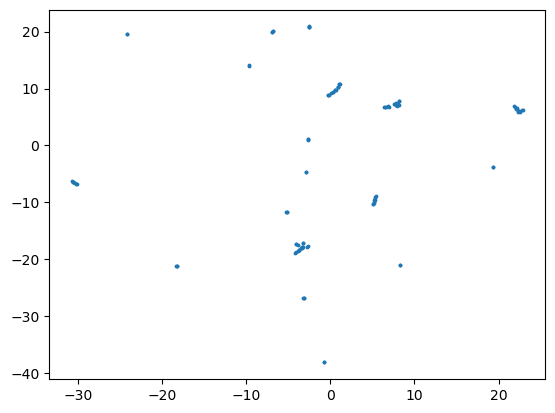

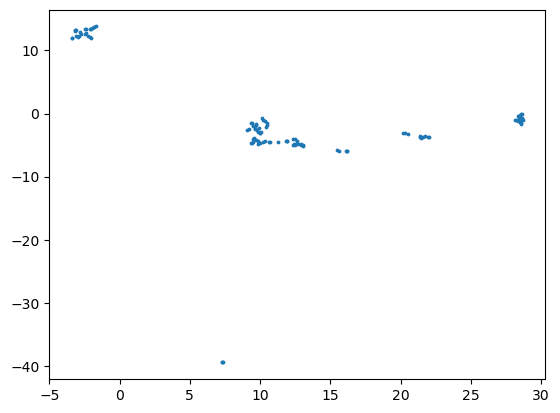

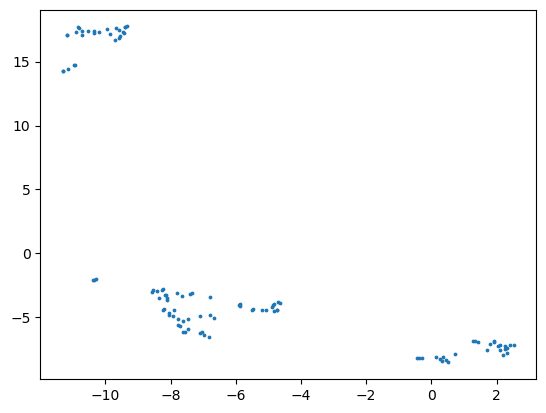

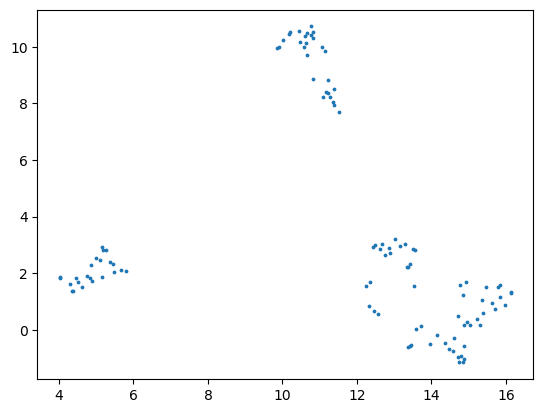

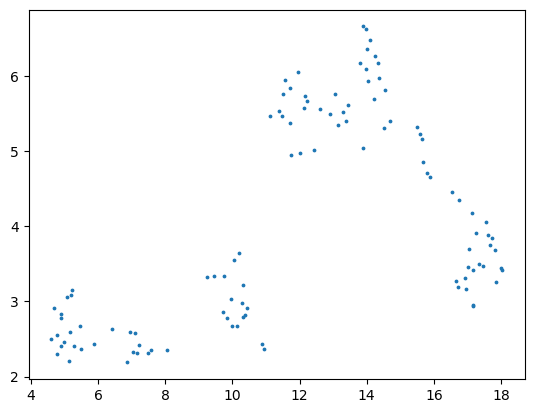

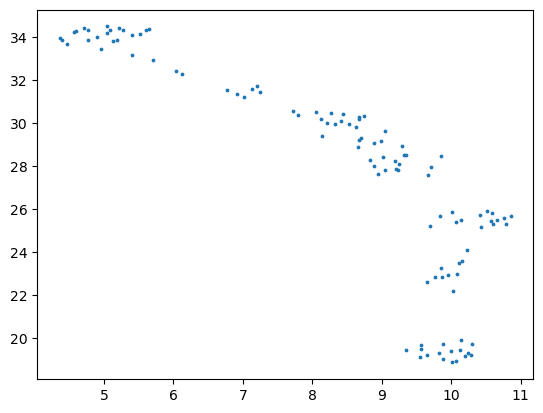

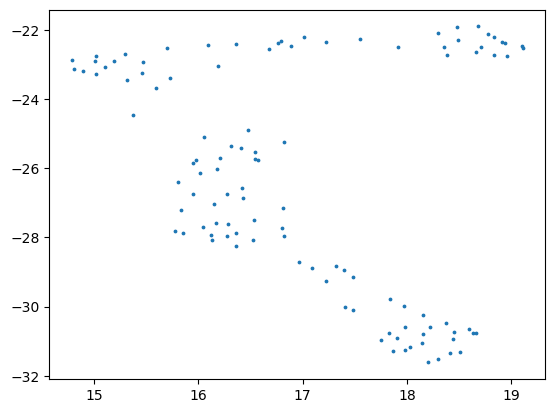

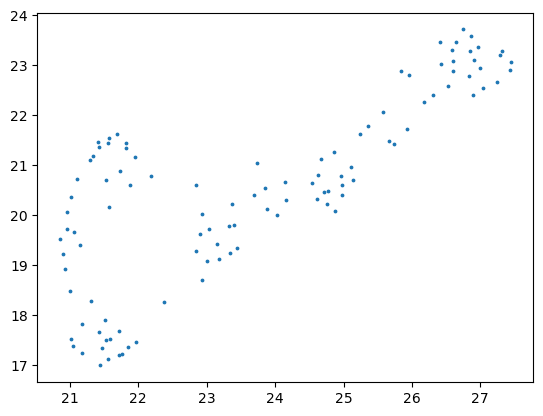

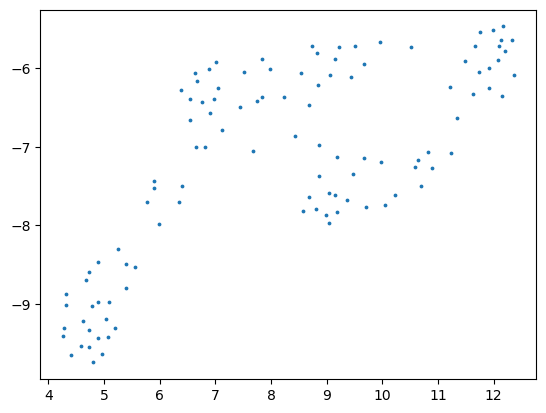

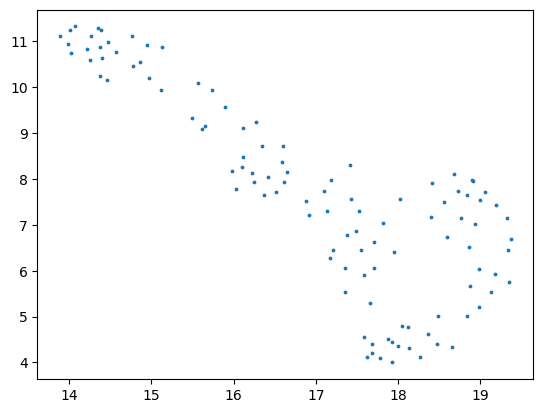

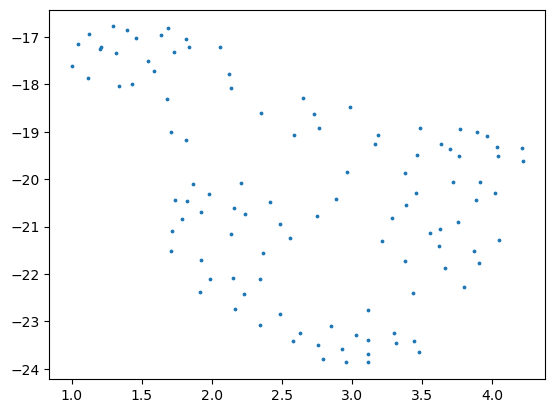

In [22]:
for n_neighbors in tqdm([2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 100]):
    plt.figure()
    plt.scatter(all_emb_2d_tsfresh_features[n_neighbors][:, 0], all_emb_2d_tsfresh_features[n_neighbors][:, 1], s=3)
    plt.show()

## Simple features

### UMAP - Clustering

  0%|          | 0/11 [00:00<?, ?it/s]

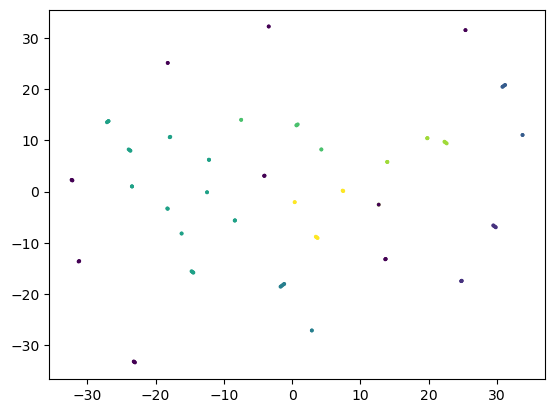

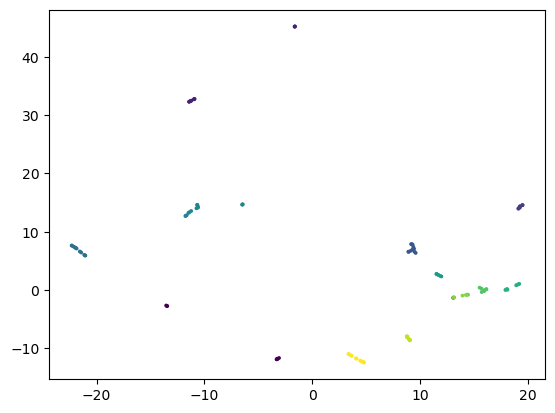

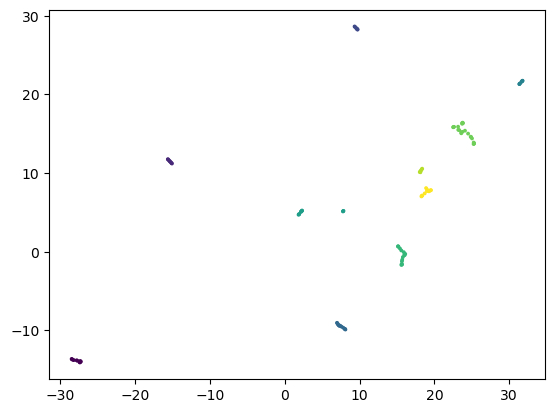

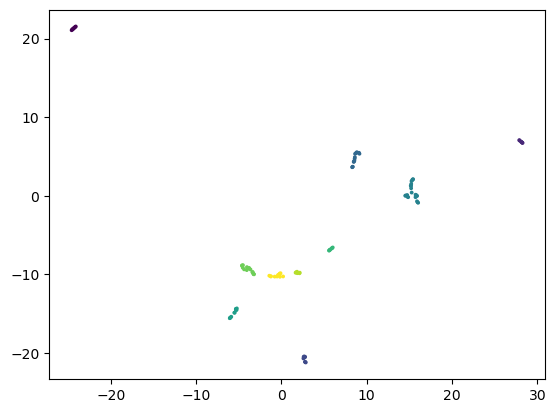

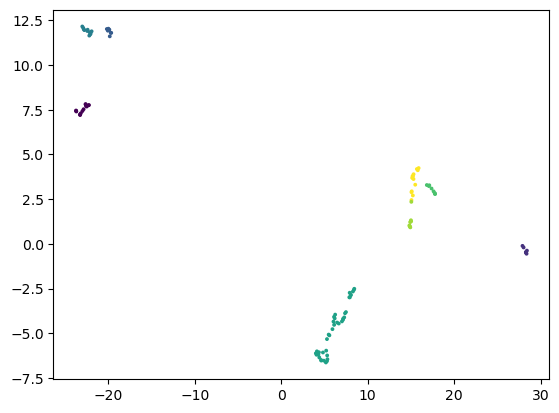

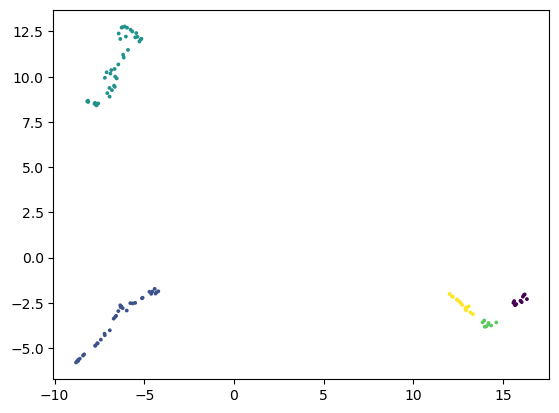

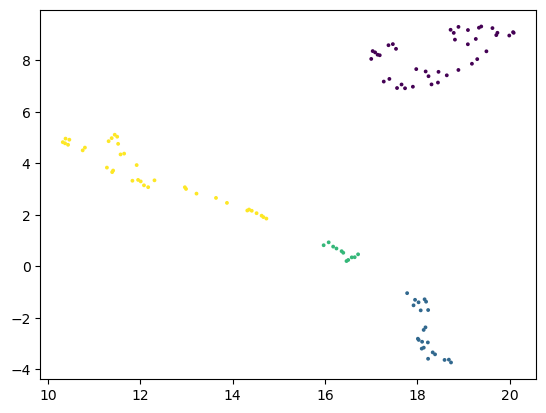

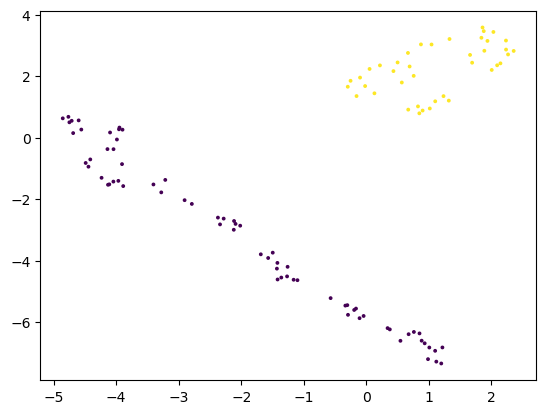

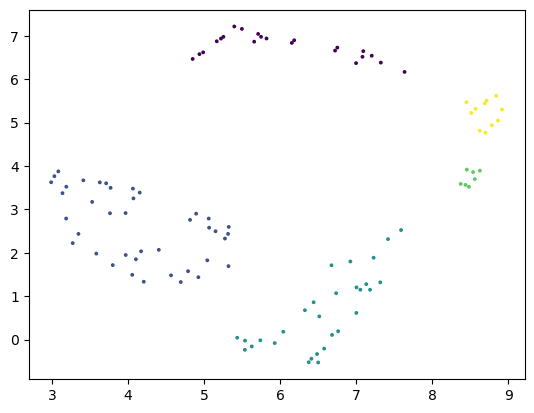

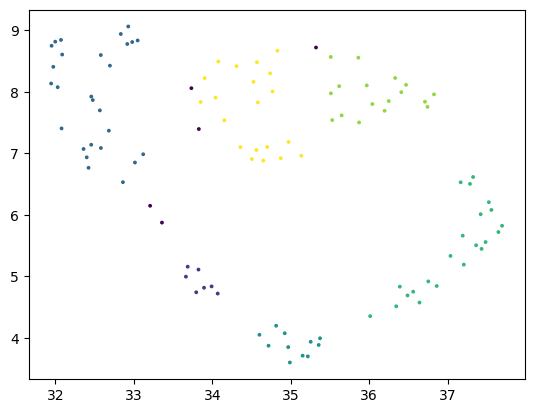

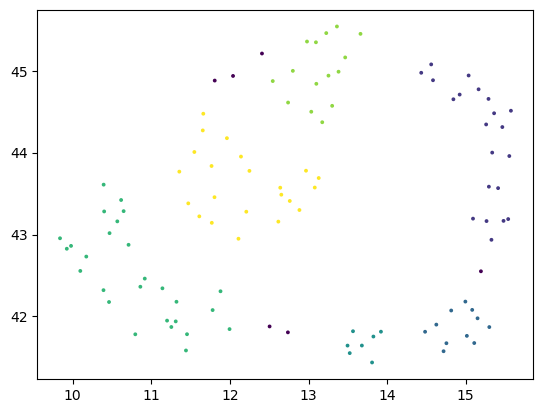

In [23]:
for n_neighbors in tqdm([2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 100]):
    clusterer = hdbscan.HDBSCAN()
    clusters = clusterer.fit_predict(all_emb_2d_features[n_neighbors])
    plt.figure()
    plt.scatter(all_emb_2d_features[n_neighbors][:, 0], all_emb_2d_features[n_neighbors][:, 1], c=clusters+1, s=3)
    plt.show()

## tsfresh features

### UMAP - Clustering

  0%|          | 0/11 [00:00<?, ?it/s]

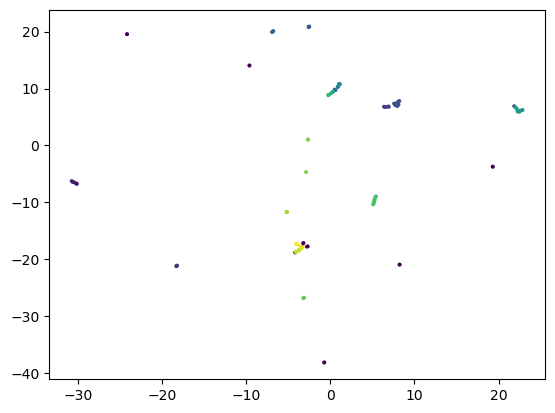

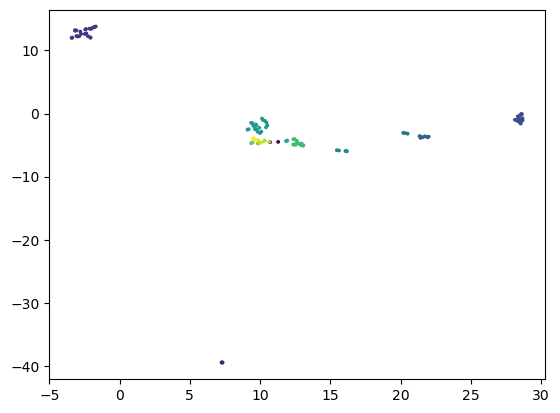

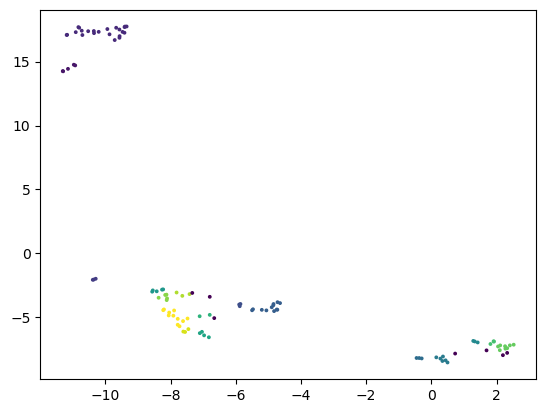

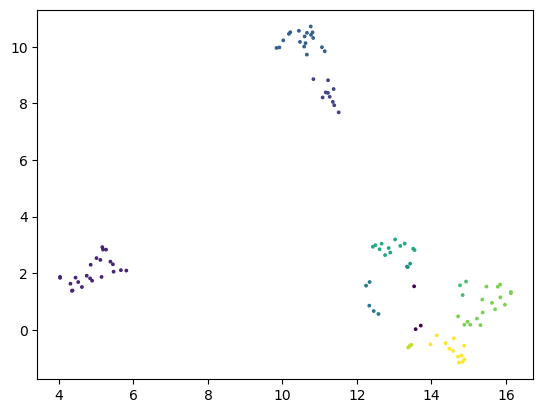

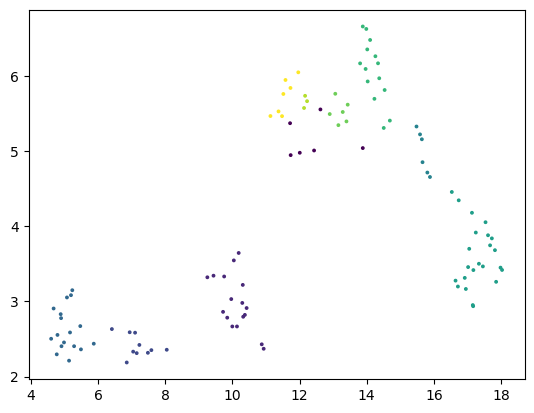

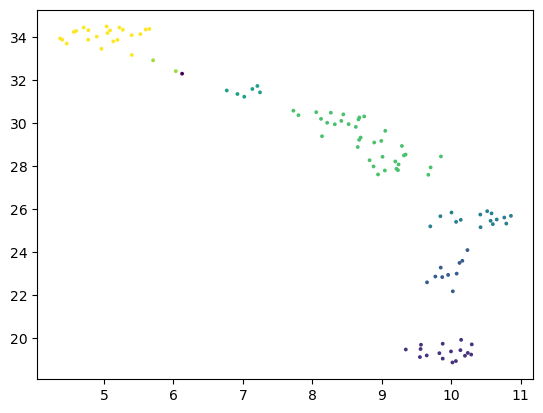

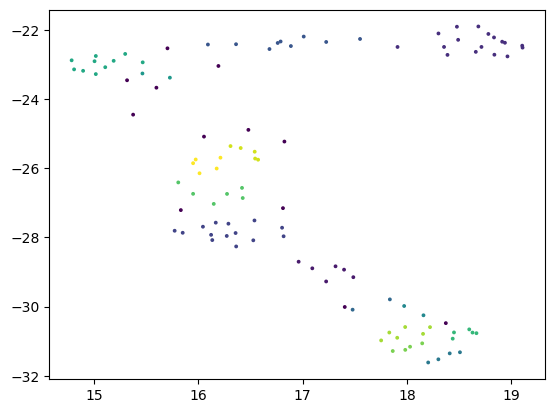

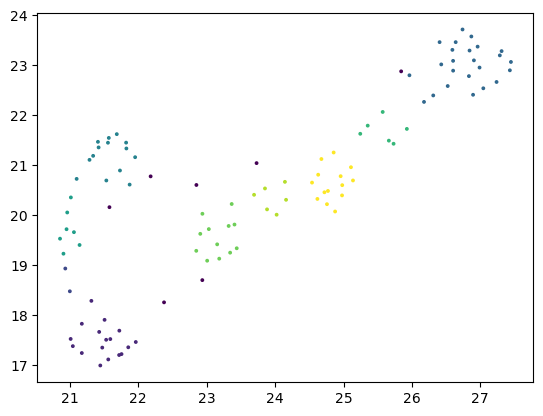

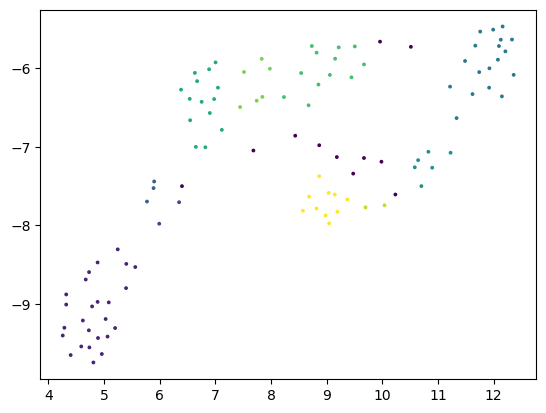

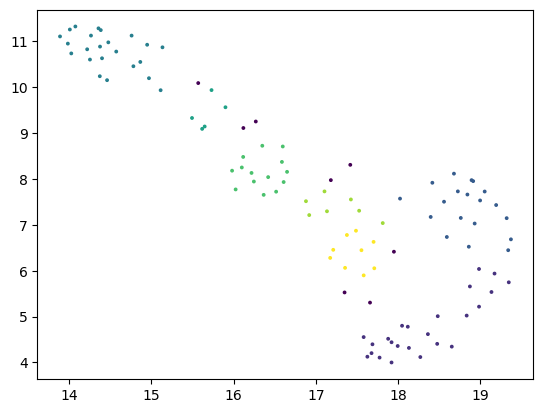

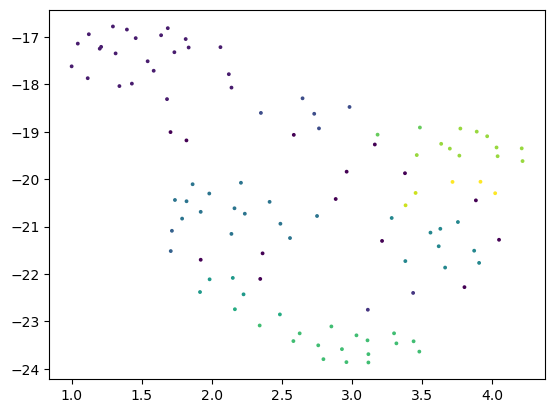

In [28]:
for n_neighbors in tqdm([2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 100]):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=2,
    )
    clusters = clusterer.fit_predict(all_emb_2d_tsfresh_features[n_neighbors])
    plt.figure()
    plt.scatter(all_emb_2d_tsfresh_features[n_neighbors][:, 0], all_emb_2d_tsfresh_features[n_neighbors][:, 1], c=clusters+1, s=3)
    plt.show()

In [41]:
from scipy.cluster.hierarchy import fcluster

Z = clusterer.single_linkage_tree_.to_numpy()
labels = fcluster(Z, 12, criterion='maxclust')

labels.max(), labels.min()

(12, 1)

In [42]:
labels

array([ 8,  6,  6,  6,  6,  8,  6,  6,  6,  6,  6,  6,  6,  6,  9,  8,  5,
        8,  6,  4,  8,  8,  8,  8,  8,  8,  8,  6,  6,  6,  6,  8,  8,  6,
        6,  1,  8,  6,  6,  6,  1,  1,  8,  8,  6,  8,  8,  1,  1,  8,  6,
        8,  8,  8,  8,  8,  6,  6,  6,  8,  6,  8,  8,  1, 10,  1,  8,  6,
        6,  1,  8,  8,  1,  1,  1,  1,  8,  6,  1,  6,  6,  7,  6,  8,  8,
        1,  1,  6,  6,  8, 11, 12,  6,  6,  6,  6,  8,  8,  6,  1,  1,  1,
        3,  2,  1,  1,  1,  8,  8], dtype=int32)

## Metrics

In [30]:
def get_ranks(selected_datasets):
    sum_ = ranks[selected_datasets[0]].copy(deep=True)
    sum_[[str(i) for i in range(30)]] *= 0
    for dataset in selected_datasets:
        sum_[[str(i) for i in range(30)]] += ranks[dataset].copy(deep=True)[[str(i) for i in range(30)]]

    mean_rank = (sum_[[str(i) for i in range(30)]] / len(selected_datasets)).mean(axis=1).values
    return mean_rank

get_ranks(chosen_datasets[:5]), get_ranks(chosen_datasets)

(array([ 4.75333333, 17.75333333, 18.82666667, 16.02666667,  6.73333333,
         7.86      , 21.99333333,  8.78      , 19.47333333, 23.47333333,
        24.08      , 24.37333333, 24.8       , 22.61333333, 22.88      ,
        22.24666667, 24.48      , 15.16666667, 20.38666667, 16.32666667,
        19.46666667,  8.06      , 22.78      , 19.84      , 20.22      ,
        22.64666667,  6.97333333,  7.13333333, 22.48666667, 22.56      ,
        10.66      , 10.15333333, 28.50666667, 23.46666667, 22.02      ]),
 array([ 6.73149847, 22.17889908, 14.12996942, 18.40611621,  6.93853211,
         9.182263  , 21.74556575, 11.982263  , 19.0030581 , 22.66819572,
        27.05718654, 25.39449541, 22.18103976, 22.44434251, 22.75504587,
        19.79143731, 25.82324159, 17.51804281, 23.63425076, 12.51314985,
        22.78287462, 10.01009174, 21.68899083, 19.07003058, 17.07278287,
        18.44220183,  6.79663609, 10.83058104, 20.10428135, 24.49724771,
        12.8412844 , 15.17370031, 24.03363914, 18

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import kendalltau, spearmanr

def get_metrics(true_ranks, pred_ranks):
    return {
        'MAE': mean_absolute_error(true_ranks, pred_ranks),
        'MSE': mean_squared_error(true_ranks, pred_ranks),
        'Kendall': kendalltau(true_ranks, pred_ranks).statistic,
        'Spearman': spearmanr(true_ranks, pred_ranks).statistic,
    }

ranks_all = get_ranks(chosen_datasets)
ranks_5 = get_ranks(chosen_datasets[:5])
get_metrics(ranks_all, ranks_5)

{'MAE': 2.4317658366098738,
 'MSE': 8.46448383977085,
 'Kendall': 0.6739495798319327,
 'Spearman': 0.838935574229692}

In [44]:
np.where(clusters == -1)[0]

array([14, 27, 31, 36, 61, 64, 76, 81, 84, 90, 91, 93, 95, 97])

In [47]:
np.argmin(np.linalg.norm(np.random.randn(5, 6) - np.random.randn(6), axis=-1))

3

In [51]:
def get_representatives(embed, clusters, datasets):
    clusters = clusters.copy()
    unclustered = (clusters == -1)
    n_unclustered = unclustered.sum()
    if n_unclustered != 0:
        clusters[unclustered] = np.arange(n_unclustered) + 1 + clusters.max()
    
    clusters = clusters - clusters.min()

    representatives = []

    for k in range(clusters.max() + 1):
        idx = np.where(clusters == k)[0]
        cluster_embed = embed[idx]
        mean_embed = cluster_embed.mean()

        dist = np.linalg.norm(mean_embed - cluster_embed, axis=-1)
        repr_idx = idx[np.argmin(dist)]
        assert clusters[repr_idx] == k
        representatives.append(repr_idx)

    return [datasets[representative] for representative in representatives]

## Automatic clustering

In [99]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
)
clusters_simple_auto = clusterer.fit_predict(all_emb_2d_features[7])

repr_simple_auto = get_representatives(all_emb_2d_features[7], clusters_simple_auto, chosen_datasets)
ranks_simple_auto = get_ranks(repr_simple_auto)
metrics_simple_auto = get_metrics(ranks_all, ranks_simple_auto)
metrics_simple_auto['repr'] = repr_simple_auto
metrics_simple_auto

{'MAE': 1.176275770246936,
 'MSE': 1.912935514403908,
 'Kendall': 0.8756302521008403,
 'Spearman': 0.9764705882352942,
 'repr': ['SwedishLeaf',
  'BeetleFly',
  'PowerCons',
  'ToeSegmentation1',
  'HouseTwenty',
  'ItalyPowerDemand',
  'MiddlePhalanxOutlineCorrect',
  'SmallKitchenAppliances',
  'OliveOil',
  'ShapesAll',
  'Crop',
  'Plane',
  'FordA',
  'Yoga',
  'MixedShapesRegularTrain',
  'EthanolLevel',
  'DistalPhalanxTW',
  'InsectWingbeatSound',
  'UWaveGestureLibraryAll',
  'ElectricDevices',
  'Fish']}

In [111]:
[print(m) for m in sorted(metrics_tsfresh_auto['repr'])]

Car
DistalPhalanxOutlineCorrect
ECGFiveDays
FaceAll
Fish
HandOutlines
HouseTwenty
ItalyPowerDemand
MixedShapesSmallTrain
PhalangesOutlinesCorrect
PowerCons
SwedishLeaf
ToeSegmentation1
TwoLeadECG
Yoga


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [98]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
)
clusters_tsfresh_auto = clusterer.fit_predict(all_emb_2d_tsfresh_features[7])

repr_tsfresh_auto = get_representatives(all_emb_2d_tsfresh_features[7], clusters_tsfresh_auto, chosen_datasets)
ranks_tsfresh_auto = get_ranks(repr_tsfresh_auto)
metrics_tsfresh_auto = get_metrics(ranks_all, ranks_tsfresh_auto)
metrics_tsfresh_auto['repr'] = repr_tsfresh_auto
metrics_tsfresh_auto

{'MAE': 1.8778738896170093,
 'MSE': 4.720803609361324,
 'Kendall': 0.8319327731092436,
 'Spearman': 0.957983193277311,
 'repr': ['PowerCons',
  'HouseTwenty',
  'ToeSegmentation1',
  'FaceAll',
  'MixedShapesSmallTrain',
  'PhalangesOutlinesCorrect',
  'HandOutlines',
  'ECGFiveDays',
  'Car',
  'DistalPhalanxOutlineCorrect',
  'Fish',
  'ItalyPowerDemand',
  'SwedishLeaf',
  'TwoLeadECG',
  'Yoga']}

## Changing number of clusters

In [76]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
)

curr_features = all_emb_2d_features[7]
clusters = clusterer.fit_predict(curr_features)
Z = clusterer.single_linkage_tree_.to_numpy()

metrics_simple = []
nn_clusters = [2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

for n_clusters in tqdm(nn_clusters):
    clusters = fcluster(Z, n_clusters, criterion='maxclust')
    
    repr_simple = get_representatives(curr_features, clusters, chosen_datasets)
    ranks_simple = get_ranks(repr_simple)
    metr = get_metrics(ranks_all, ranks_simple)
    metr['repr'] = repr_simple
    metrics_simple.append(metr)

  0%|          | 0/15 [00:00<?, ?it/s]

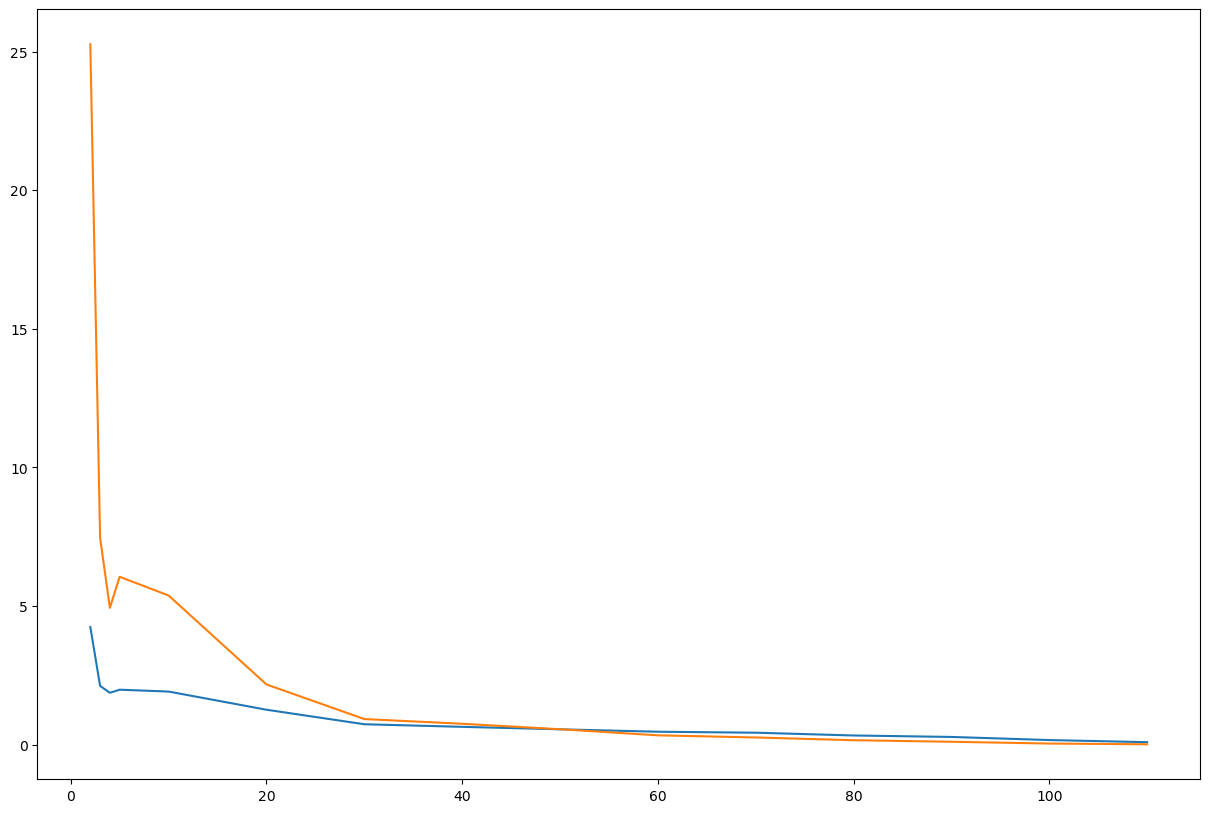

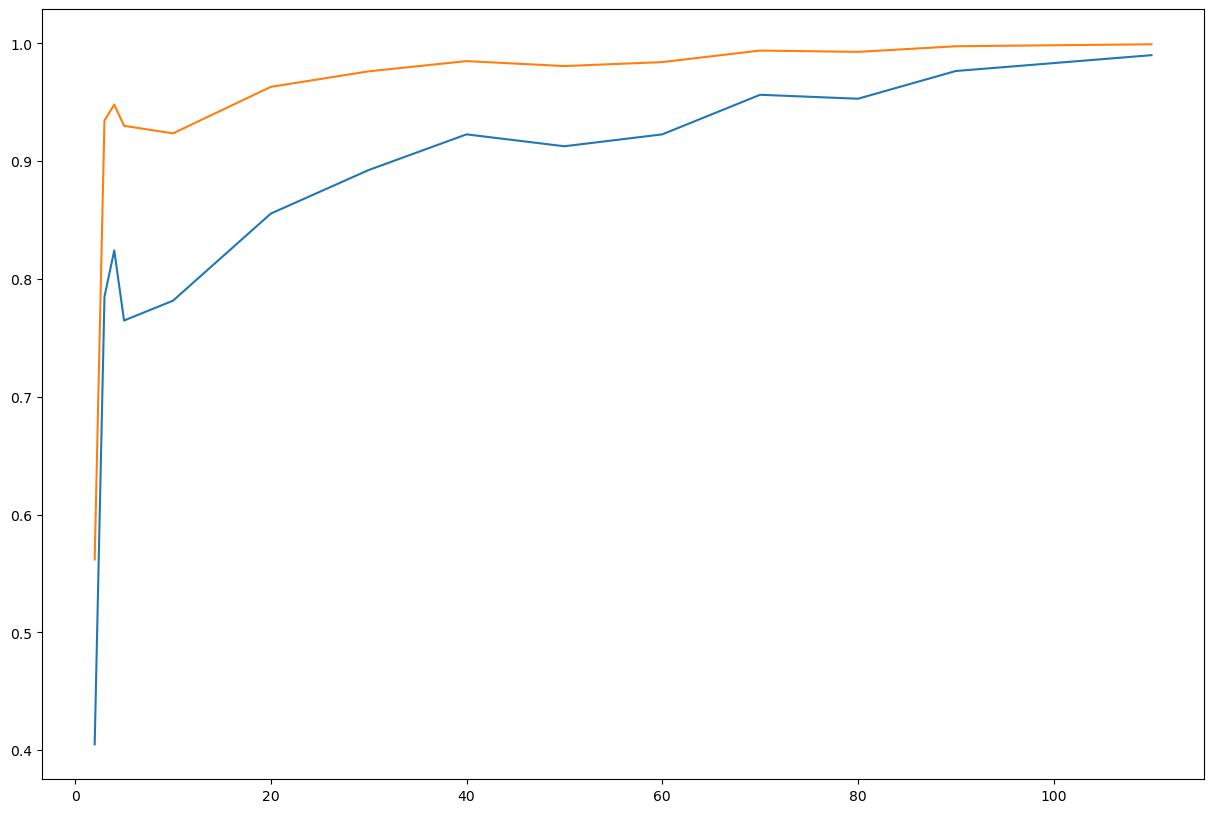

In [77]:
plt.figure(figsize=(15, 10))

plt.plot(nn_clusters, [m['MAE'] for m in metrics_simple])
plt.plot(nn_clusters, [m['MSE'] for m in metrics_simple])

plt.show()

plt.figure(figsize=(15, 10))
plt.plot(nn_clusters, [m['Kendall'] for m in metrics_simple])
plt.plot(nn_clusters, [m['Spearman'] for m in metrics_simple])

plt.show()

In [78]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
)

curr_features = all_emb_2d_tsfresh_features[7]
clusters = clusterer.fit_predict(curr_features)
Z = clusterer.single_linkage_tree_.to_numpy()

metrics_tsfresh = []
nn_clusters = [2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

for n_clusters in tqdm(nn_clusters):
    clusters = fcluster(Z, n_clusters, criterion='maxclust')
    
    repr_tsfresh = get_representatives(curr_features, clusters, chosen_datasets)
    ranks_tsfresh = get_ranks(repr_tsfresh)
    metr = get_metrics(ranks_all, ranks_tsfresh)
    metr['repr'] = repr_tsfresh
    metrics_tsfresh.append(metr)

  0%|          | 0/15 [00:00<?, ?it/s]

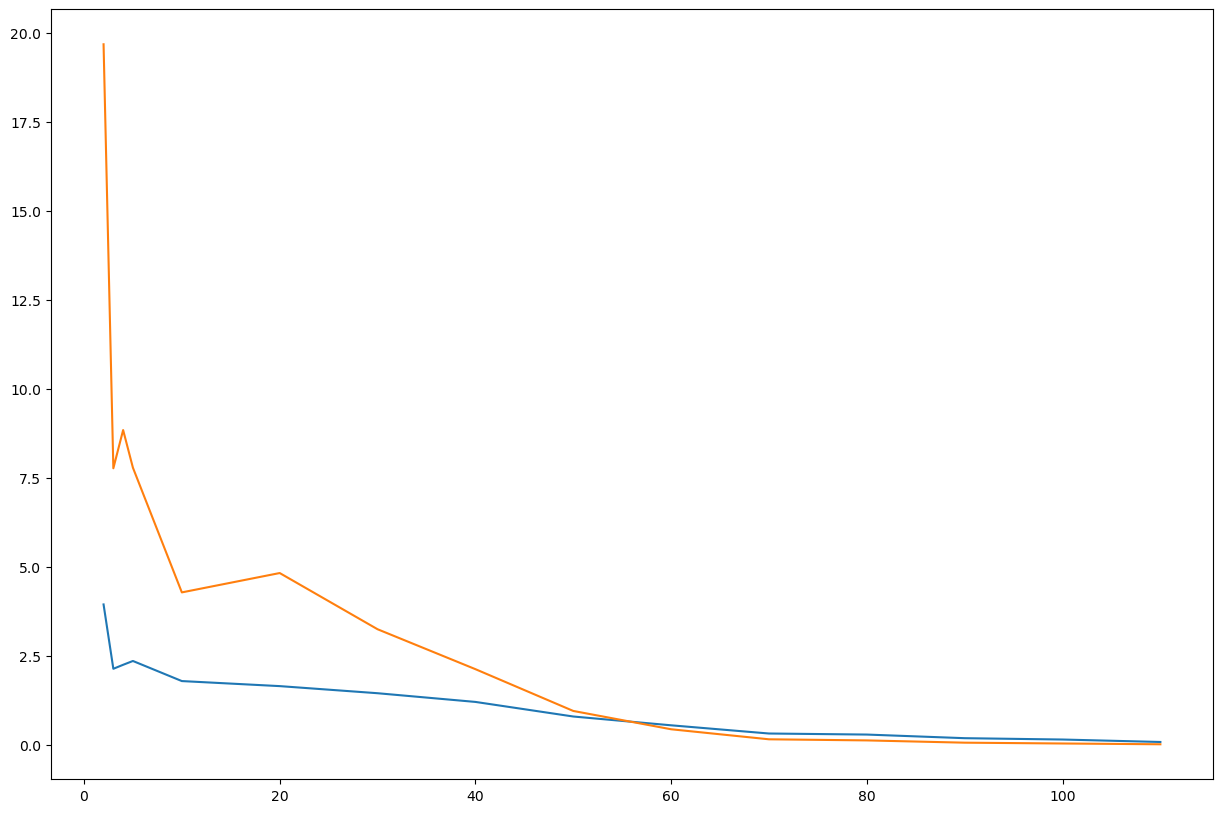

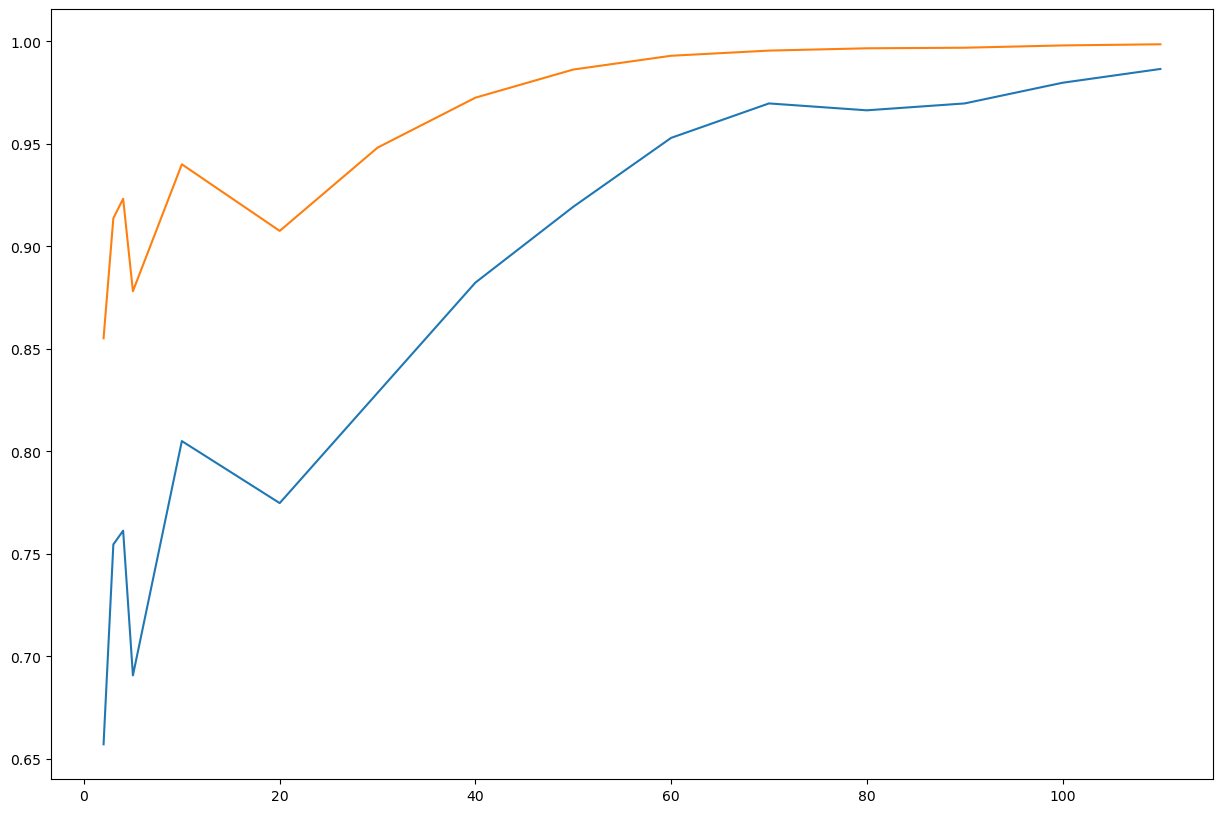

In [79]:
plt.figure(figsize=(15, 10))

plt.plot(nn_clusters, [m['MAE'] for m in metrics_tsfresh])
plt.plot(nn_clusters, [m['MSE'] for m in metrics_tsfresh])

plt.show()

plt.figure(figsize=(15, 10))
plt.plot(nn_clusters, [m['Kendall'] for m in metrics_tsfresh])
plt.plot(nn_clusters, [m['Spearman'] for m in metrics_tsfresh])

plt.show()

## Visualizing

In [90]:
nn_clusters

[2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

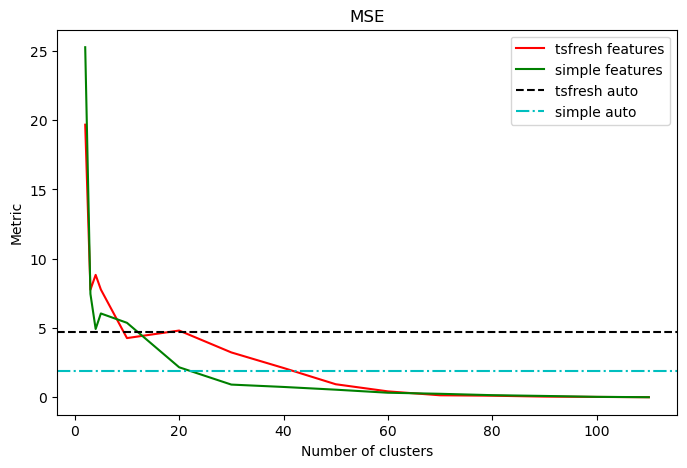

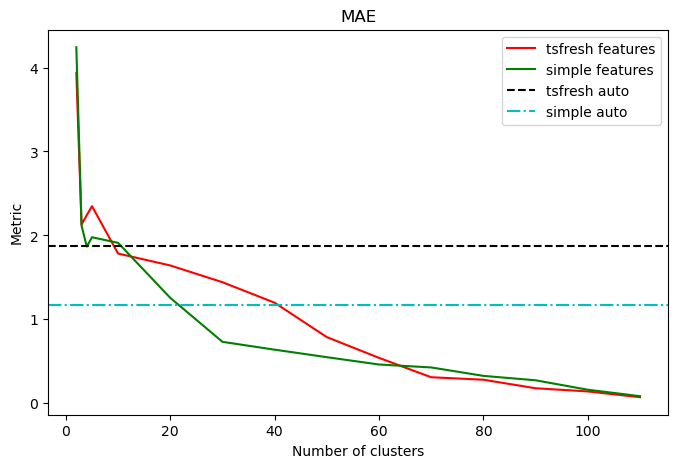

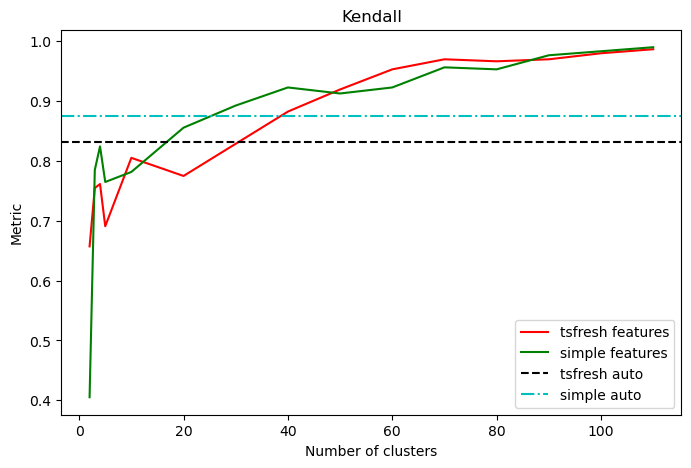

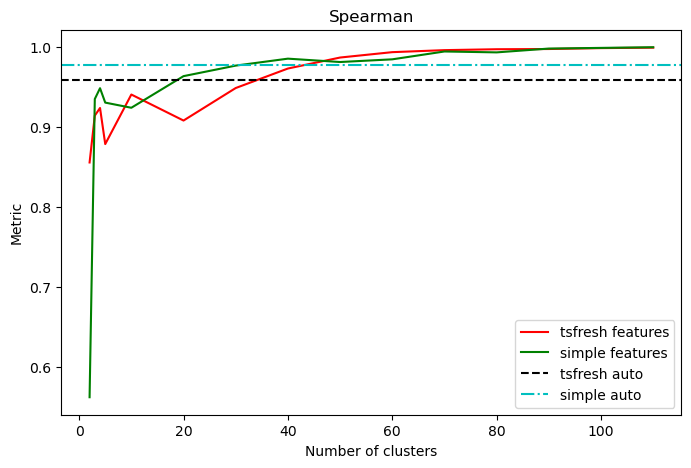

In [97]:
for metric_name in ["MSE", "MAE", "Kendall", "Spearman"]:
    plt.figure(figsize=(8, 5))

    plt.plot(nn_clusters, [m[metric_name] for m in metrics_tsfresh], label='tsfresh features', color='r')
    plt.plot(nn_clusters, [m[metric_name] for m in metrics_simple], label='simple features', color='g')

    plt.axhline(metrics_tsfresh_auto[metric_name], label='tsfresh auto', linestyle='--', color='k')
    plt.axhline(metrics_simple_auto[metric_name], label='simple auto', linestyle='-.', color='c')

    plt.title(metric_name)
    plt.xlabel('Number of clusters')b
    plt.ylabel('Metric')
    
    plt.legend()

    plt.savefig(f"{metric_name}_all.png")
    plt.plot()

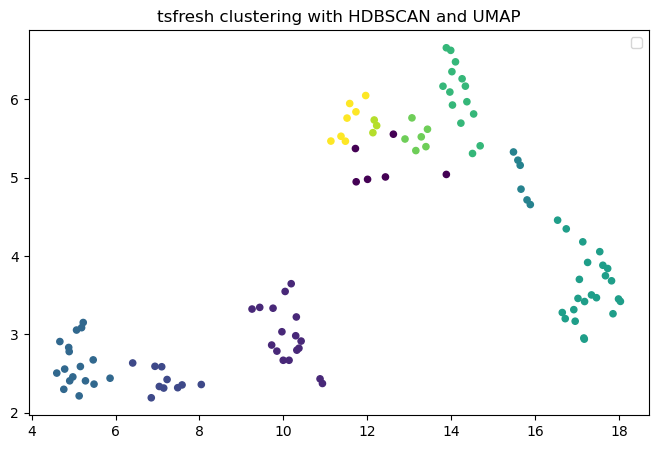

In [114]:
curr_embed = all_emb_2d_tsfresh_features[7]
plt.figure(figsize=(8, 5))
plt.scatter(curr_embed[:, 0], curr_embed[:, 1], c=clusters_tsfresh_auto+1, s=20)
plt.title("tsfresh clustering with HDBSCAN and UMAP")
plt.legend()
plt.savefig("umaped_clustered_tsfresh.png")
plt.show()

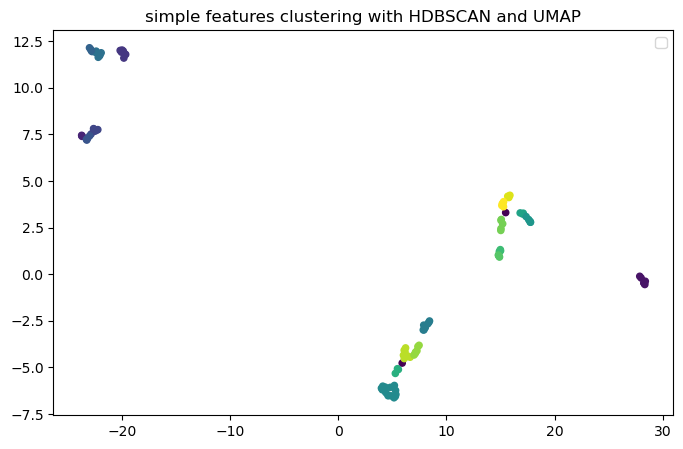

In [115]:
curr_embed = all_emb_2d_features[7]
plt.figure(figsize=(8, 5))
plt.scatter(curr_embed[:, 0], curr_embed[:, 1], c=clusters_simple_auto+1, s=20)
plt.title("simple features clustering with HDBSCAN and UMAP")
plt.legend()
plt.savefig("umaped_simple_tsfresh.png")
plt.show()